In [1]:
%matplotlib notebook

In [2]:
import serial,sys,time,math,datetime,os
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [4]:
ser = serial.Serial()
ser.port = "/dev/ttyUSB3"
ser.baudrate = 115200
ser.timeout = 2.0
ser.open()

In [5]:
ser.write('++addr\n'.encode('ascii'))
print(ser.readline().decode().rstrip())
ser.write('++addr 16\n'.encode('ascii'))
ser.write('++addr\n'.encode('ascii'))
print(ser.readline().decode().rstrip())

16
16


In [6]:
ser.write('++auto\n'.encode('ascii'))
print(ser.readline().decode().rstrip())
ser.write('++auto 0\n'.encode('ascii'))
ser.write('++auto\n'.encode('ascii'))
print(ser.readline().decode().rstrip())

0
0


In [7]:
ser.write('++eos 3\n'.encode('ascii'))
print(ser.readline().decode().rstrip())

In [8]:
ser.write('++savecfg 0\n'.encode('ascii'))
print(ser.readline().decode().rstrip())

In [9]:
ser.write('STAR?;\n'.encode('ascii'))
time.sleep(0.1)
ser.write('++read eoi\n'.encode('ascii'))
print(repr(ser.read(2048).decode()))

'   1.000000000000000E+09\n'


In [10]:
ser.write('POWR?;\n'.encode('ascii'))
time.sleep(0.1)
ser.write('++read eoi\n'.encode('ascii'))
print(repr(ser.read(2048).decode()))

'0\n'


In [ ]:
ser.write('POIN?;\n'.encode('ascii'))
time.sleep(0.1)
ser.write('++read eoi\n'.encode('ascii'))
print(repr(ser.read(2048).decode()))

In [ ]:
ser.write('AVFRO?;\n'.encode('ascii'))
time.sleep(0.1)
ser.write('++read eoi\n'.encode('ascii'))
print(repr(ser.read(2048).decode()))

In [ ]:
ser.write('++read eoi\n'.encode('ascii'))
print(repr(ser.read(2048).decode()))

In [5]:
def read_line_gpib():
    ser.write('++read eoi\n'.encode('ascii'))
    return ser.readline().decode().rstrip()

def read_all_gpib():
    time.sleep(5)
    ser.write('++read eoi\n'.encode('ascii'))
    ser.timeout = 0.5    
    resp = bytes()
    cnt = 0
    lentot = 0
    for i in range(1,5000):
        resppart = ser.read(10000)
        time.sleep(0.01)
        #print(len(resppart))
        if (len(resppart) == 0):
            cnt += 1
        else:
            lentot += len(resppart)
            cnt = 0
            resp += resppart
        if (cnt>200):
            break 
    print('Read {} bytes'.format(lentot))
    return resp

def read_all_gpib_withtarget(amt):
    time.sleep(5)    
    ser.timeout = 0.5   
    resp = bytes()
    cnt = 0
    lentot = 0
    st = timer()
    ser.write('++read eoi\n'.encode('ascii'))
    for i in range(1,5000):
        if (timer()-st > 3):
            ser.write('++read eoi\n'.encode('ascii'))
            st = timer()
        time.sleep(0.01)
        resppart = ser.read(100000)
        time.sleep(0.01)
        print(len(resppart))
        if (len(resppart) == 0):
            cnt += 1
        else:
            lentot += len(resppart)
            cnt = 0
            resp += resppart
        if (cnt>200):
            break 
        if (lentot>=amt):
            break
    print('Read {} bytes'.format(lentot))
    ser.timeout = 0.5
    return resp
        
def wtf():   
    return ser.read(64000).decode('ascii').rstrip()

def flush_gpib():    
    ser.write('++read eoi\n'.encode('ascii'))
    time.sleep(3.1)
    return ser.read(512000).decode('ascii').rstrip()

def set_tm():
    ser.write('++read_tmo_ms 3000\n'.encode('ascii'))

def send_command_with_resp(cmd):
    ser.write('{}\n'.format(cmd).encode('ascii'))
    time.sleep(0.05)
    return read_line_gpib()
    
def send_command_no_resp(cmd):
    ser.write('{}\n'.format(cmd).encode('ascii'))
    
def await_confirmation(tm):
    start = timer();
    while (read_line_gpib() != '1' and timer()-start < tm):
        time.sleep(1)
    print("Confirmation received in {:3.2f}s".format(timer()-start))
    
def get_value_lists(text):
    ans3 = text.split('\n')
    ilist = []
    qlist = []
    for s in ans3:
        if s != '':
            #print(s)
            strarr = s.split(',')        
            ilist.append(float(strarr[0]))
            qlist.append(float(strarr[1]))
    return [ilist,qlist]

In [ ]:
print(flush_gpib())

In [24]:
set_tm()

In [6]:
flush_gpib()
start = float(send_command_with_resp('STAR?;'))
npoints = int(float(send_command_with_resp('POIN?;')))
span = float(send_command_with_resp('SPAN?;'))
ifbw = int(float(send_command_with_resp('IFBW?;')))
#pwr = float(send_command_with_resp('POWE?;'))
pwr = -10.0
print("Scanning [{} to {}] with {} points, IFBW of {} at {} dBm".format(start,start+span,npoints,ifbw,pwr))
send_command_no_resp('FORM4;')
send_command_no_resp('OPC?;SING;')
await_confirmation(250.0)

Scanning [200000000.0 to 2000000000.0] with 1601 points, IFBW of 10 at -10.0 dBm
Confirmation received in 171.19s


In [7]:
send_command_no_resp('OUTPFORM;')

In [8]:
response = read_all_gpib_withtarget(80050)

0
0
0
0
80050
Read 80050 bytes


<IPython.core.display.Javascript object>


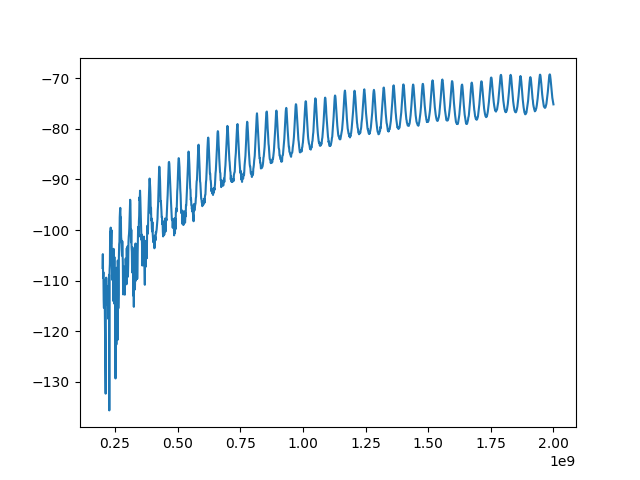

In [9]:
plt.figure()
[il,ql] = get_value_lists(response.decode('ascii'))
plt.plot(list(np.linspace(start,start+span,npoints)),il,'-')
plt.show()

In [10]:
date = datetime.datetime.now()
logroot = '/home/pi/Desktop/DataNX/vna/'
logdir = logroot+date.strftime('%Y%m%d')
if not os.path.isdir(logdir):
    print("Directory |{}| not there, making".format(logdir))
    os.mkdir(logdir)
dirs = os.listdir(logroot)
print(dirs)
logfile = logdir+os.path.sep+date.strftime('vnasweep-%H-%M-%S.txt')
print(logfile)


Directory |/home/pi/Desktop/DataNX/vna/20170726| not there, making
['.ipynb_checkpoints', '20170726', '20170717']
/home/pi/Desktop/DataNX/vna/20170726/vnasweep-12-12-41.txt


In [11]:
fl = open(logfile, "w")
time.sleep(0.05)
fl.write('DATE: {}\n'.format(date.strftime('%Y/%m/%d')))
fl.write('TIME: {}\n'.format(date.strftime('%H:%M:%S')))
fl.write('POWER: {}\n'.format(pwr))
fl.write('IFBW: {}\n'.format(ifbw))
fl.write('STIMULUS, REAL, IMAGINARY\n')
fl.write('\n')
freqs = list(np.linspace(start,start+span,npoints))
[il,ql] = get_value_lists(response.decode('ascii'))
if len(freqs) != len(il):
    print("BAD")
else:
    for i in range(0,len(freqs)):
        try:
            fl.write('{:12.10E}, {:12.10E}, {:12.10E}\n'.format(freqs[i],il[i],ql[i]))
            print(i)
        except Exception as e:
            print(e)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
[il,ql] = get_value_lists(response.decode('ascii'))
datatoplot = [10.0*math.log10((il[i]**2+ql[i]**2)/(50.0*.001)) for i in range(0,len(il))]

<IPython.core.display.Javascript object>


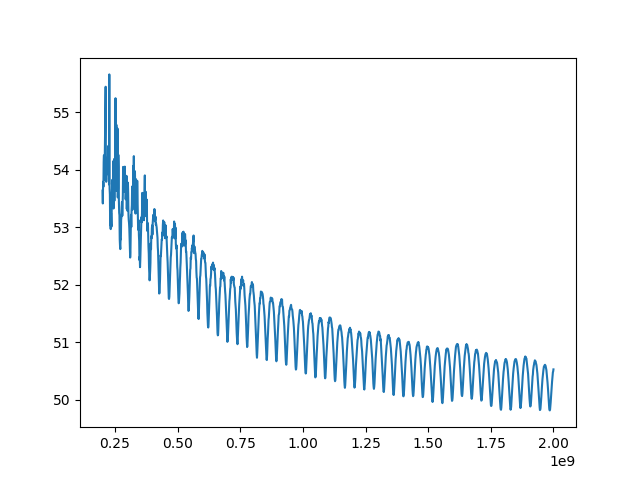

In [13]:
plt.figure()
plt.plot(list(np.linspace(start,start+span,npoints)),datatoplot,'-')
plt.show()

In [ ]:
send_command_no_resp('OPC?;SING;')

In [ ]:
send_command_no_resp('POIN1601;')

In [ ]:
send_command_no_resp('IFBW10;')

In [ ]:
send_command_no_resp('PRES;')

In [ ]:
send_command_no_resp('S21;')

In [ ]:
send_command_no_resp('LOGM;')

In [ ]:
send_command_no_resp('POWE-10.0;')

In [ ]:
send_command_no_resp('POLA;')

In [ ]:
send_command_no_resp('OUTPDATA;')

In [ ]:
response = read_all_gpib()

In [ ]:
print(response)

In [65]:
print(freqs)

[600000000.0, 600062500.0, 600125000.0, 600187500.0, 600250000.0, 600312500.0, 600375000.0, 600437500.0, 600500000.0, 600562500.0, 600625000.0, 600687500.0, 600750000.0, 600812500.0, 600875000.0, 600937500.0, 601000000.0, 601062500.0, 601125000.0, 601187500.0, 601250000.0, 601312500.0, 601375000.0, 601437500.0, 601500000.0, 601562500.0, 601625000.0, 601687500.0, 601750000.0, 601812500.0, 601875000.0, 601937500.0, 602000000.0, 602062500.0, 602125000.0, 602187500.0, 602250000.0, 602312500.0, 602375000.0, 602437500.0, 602500000.0, 602562500.0, 602625000.0, 602687500.0, 602750000.0, 602812500.0, 602875000.0, 602937500.0, 603000000.0, 603062500.0, 603125000.0, 603187500.0, 603250000.0, 603312500.0, 603375000.0, 603437500.0, 603500000.0, 603562500.0, 603625000.0, 603687500.0, 603750000.0, 603812500.0, 603875000.0, 603937500.0, 604000000.0, 604062500.0, 604125000.0, 604187500.0, 604250000.0, 604312500.0, 604375000.0, 604437500.0, 604500000.0, 604562500.0, 604625000.0, 604687500.0, 604750000.0

In [ ]:
print(send_command_with_resp('POWE?;'))

In [ ]:
ser.write('OUTPDATA;\n'.encode('ascii'))

In [ ]:
ser.timeout = 0.1
ser.write('++read eoi\n'.encode('ascii'))
time.sleep(0.1)
cnt = 0
lentot = 0
for i in range(1,100):
    resppart = ser.read(128000)
    print(len(resppart))
    lentot += len(resppart)
    if (len(resppart) == 0):
        cnt += 1
    if (cnt>50):
        break
    
print(lentot)

In [ ]:
ser.timeout = 0.1
ser.write('++read eoi\n'.encode('ascii'))
time.sleep(0.1)
cnt = 0
lentot = 0
for i in range(1,100):
    resppart = ser.read(2048)
    print(len(resppart))
    lentot += len(resppart)
    if (len(resppart) == 0):
        cnt += 1
    if (cnt>50):
        break
    
print(lentot)


In [ ]:
print(send_command_with_resp('OUTPEERO;'))

In [ ]:
len(il)

In [ ]:
print(read_line_gpib())

In [ ]:
print(read_all_gpib())

In [ ]:
ser.write('++read eoi\n'.encode('ascii'))
ans = ser.read(2048)
print(repr(ans))
ans2 = ans.decode('ascii')
print(repr(ans2))
[il,ql] = get_value_lists(ans2)
plt.plot(ilist,'-')
plt.show()

In [ ]:
ser.write('++help\n'.encode('ascii'))
print(ser.read(2048).decode())

In [ ]:
ser.close()